# NYC Taxi Data - Cleaning & Feature Engineering



1. **Data Loading & Initial Inspection**
2. **Data Cleaning**
   - Handle missing values
   - Remove duplicates
   - Fix data type issues
   - Filter out invalid values (negative distances, illogical timestamps, etc.)
3. **Feature Engineering**
   - Trip duration in minutes
   - Total trip cost
   - Time-based features (hour, day, month)
   - Spatial features (borough, zone enrichment)
4. **Integration of Zone Data with Trip Data**
5. **Visualization of Cleaned Dataset**
6. **Saving the Processed Dataset**

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, to_timestamp, unix_timestamp, from_unixtime
from pyspark.sql.functions import hour, dayofweek, month, year, minute, round as spark_round
from pyspark.sql.types import DoubleType, IntegerType, StringType
import os

# Set better visualization defaults
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 8]
sns.set(font_scale=1.2)

# Initialize Spark session
spark = SparkSession.builder \
    .appName("NYC Taxi Data Cleaning") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

# Load the data
print("Loading data...")
df_trip_data = spark.read.csv("/root/DevDataOps/Datasets/taxi_analysis/taxi_trip_data.csv", header=True, inferSchema=True)
df_zone_geo = spark.read.csv("/root/DevDataOps/Datasets/taxi_analysis/taxi_zone_geo.csv", header=True, inferSchema=True)

# Show sample data
print("Trip Data Sample:")
df_trip_data.show(5)
print("\nZone Data Sample:")
df_zone_geo.show(5)

# Check data info
print("\nTrip Data Schema:")
df_trip_data.printSchema()
print("\nZone Data Schema:")
df_zone_geo.printSchema()

# Check data counts
print(f"\nTrip Data Count: {df_trip_data.count():,}")
print(f"Zone Data Count: {df_zone_geo.count():,}")

your 131072x1 screen size is bogus. expect trouble
25/05/21 02:27:23 WARN Utils: Your hostname, DESKTOP-L4AHF1L resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/05/21 02:27:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/05/21 02:27:23 WARN Utils: Your hostname, DESKTOP-L4AHF1L resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/05/21 02:27:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/21 02:27:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/21 02:27:27 WARN NativeCodeLoader: Unable to load native-hadoo

Loading data...


Trip Data Sample:
+---------+----------------+----------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------------+-------------------+
|vendor_id| pickup_datetime|dropoff_datetime|passenger_count|trip_distance|rate_code|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|imp_surcharge|pickup_location_id|dropoff_location_id|
+---------+----------------+----------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------------+-------------------+
|        1| 5/11/2018 17:40| 5/11/2018 17:55|              1|          1.6|        1|                 N|           1|       11.5|  1.0|    0.5|       0.0|         0.0|          0.3|                48|                 68|
|        2| 3/22/2018 23:01| 3/22/2018 23:25|              1|         9.52|        1|             

## 1. Data Quality Assessment

Let's first check for missing values, duplicates, and invalid data based on our exploratory analysis.

In [3]:
# Check for missing values in trip data
print("Missing Values in Trip Data:")
trip_null_counts = df_trip_data.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df_trip_data.columns])
trip_null_counts.show()

# Check for missing values in zone data
print("Missing Values in Zone Data:")
zone_null_counts = df_zone_geo.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df_zone_geo.columns])
zone_null_counts.show()

# Check for duplicate rows in trip data
trip_duplicates = df_trip_data.count() - df_trip_data.dropDuplicates().count()
print(f"Number of duplicate rows in trip data: {trip_duplicates}")

# Check for invalid values
from pyspark.sql.functions import col

# Check for negative/zero trip distance
invalid_distance = df_trip_data.filter(col("trip_distance") <= 0).count()
print(f"Trips with invalid distance (≤ 0): {invalid_distance}")

# Check for negative fare amount
invalid_fare = df_trip_data.filter(col("fare_amount") < 0).count()
print(f"Trips with negative fare amount: {invalid_fare}")

# Check for zero passenger count
zero_passengers = df_trip_data.filter(col("passenger_count") == 0).count()
print(f"Trips with zero passengers: {zero_passengers}")

# Check for unreasonable passenger counts (> 6)
high_passengers = df_trip_data.filter(col("passenger_count") > 6).count()
print(f"Trips with unreasonably high passenger count (> 6): {high_passengers}")

# Convert datetime strings to timestamp for logical checks
df_with_timestamps = df_trip_data.withColumn(
    "pickup_ts", to_timestamp(col("pickup_datetime"), "M/d/yyyy H:mm")
).withColumn(
    "dropoff_ts", to_timestamp(col("dropoff_datetime"), "M/d/yyyy H:mm")
)

# Check for trips where dropoff is before pickup
invalid_times = df_with_timestamps.filter(
    col("dropoff_ts") < col("pickup_ts")
).count()
print(f"Trips with dropoff before pickup: {invalid_times}")

# Check for trips with unreasonable duration (> 24 hours)
unreasonable_duration = df_with_timestamps.filter(
    (unix_timestamp(col("dropoff_ts")) - unix_timestamp(col("pickup_ts"))) > 24 * 3600
).count()
print(f"Trips with unreasonable duration (> 24 hours): {unreasonable_duration}")

Missing Values in Trip Data:


+---------+---------------+----------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------------+-------------------+
|vendor_id|pickup_datetime|dropoff_datetime|passenger_count|trip_distance|rate_code|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|imp_surcharge|pickup_location_id|dropoff_location_id|
+---------+---------------+----------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------------+-------------------+
|        0|              0|               0|              0|            0|        0|                 0|           0|          0|    0|      0|         0|           0|            0|                 0|                  0|
+---------+---------------+----------------+---------------+-------------+---------+------------------+------------+----

Number of duplicate rows in trip data: 835


25/05/21 02:27:41 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Trips with invalid distance (≤ 0): 7143
Trips with negative fare amount: 668
Trips with negative fare amount: 668
Trips with zero passengers: 9408
Trips with zero passengers: 9408
Trips with unreasonably high passenger count (> 6): 7
Trips with unreasonably high passenger count (> 6): 7


Trips with dropoff before pickup: 8


Trips with unreasonable duration (> 24 hours): 0


## 2. Data Cleaning

Now let's clean our data based on the quality assessment:
1. Fix data types
2. Remove duplicates
3. Handle missing values
4. Filter out invalid data

In [4]:
# Step 1: Fix data types
cleaned_trip_data = df_trip_data.withColumn(
    "pickup_datetime", to_timestamp(col("pickup_datetime"), "M/d/yyyy H:mm")
).withColumn(
    "dropoff_datetime", to_timestamp(col("dropoff_datetime"), "M/d/yyyy H:mm")
).withColumn(
    "passenger_count", col("passenger_count").cast(IntegerType())
).withColumn(
    "trip_distance", col("trip_distance").cast(DoubleType())
).withColumn(
    "fare_amount", col("fare_amount").cast(DoubleType())
).withColumn(
    "tip_amount", col("tip_amount").cast(DoubleType())
).withColumn(
    "tolls_amount", col("tolls_amount").cast(DoubleType())
).withColumn(
    "imp_surcharge", col("imp_surcharge").cast(DoubleType())
).withColumn(
    "pickup_location_id", col("pickup_location_id").cast(IntegerType())
).withColumn(
    "dropoff_location_id", col("dropoff_location_id").cast(IntegerType())
)

# Step 2: Remove duplicates
cleaned_trip_data = cleaned_trip_data.dropDuplicates()

# Step 3: Handle missing values
# For numeric columns: replace nulls with column median
from pyspark.sql.functions import lit

# Get median values for numeric columns
numeric_columns = ["trip_distance", "fare_amount", "tip_amount", "tolls_amount", "passenger_count", "extra", "mta_tax", "imp_surcharge"]
medians = {}

for col_name in numeric_columns:
    median_df = cleaned_trip_data.select(col_name).approxQuantile(col_name, [0.5], 0.01)
    medians[col_name] = median_df[0]

# Fill nulls with medians
for col_name in numeric_columns:
    cleaned_trip_data = cleaned_trip_data.withColumn(
        col_name, 
        when(col(col_name).isNull() | isnan(col(col_name)), medians[col_name]).otherwise(col(col_name))
    )

# Step 4: Filter out invalid data
cleaned_trip_data = cleaned_trip_data.filter(
    # Keep only valid distances
    (col("trip_distance") > 0) & 
    # Keep only valid fares
    (col("fare_amount") >= 0) &
    # Keep valid passenger counts (1-6)
    (col("passenger_count") > 0) & 
    (col("passenger_count") <= 6) &
    # Ensure dropoff is after pickup
    (col("dropoff_datetime") > col("pickup_datetime")) &
    # Ensure trip duration is reasonable (under 24 hours)
    ((unix_timestamp(col("dropoff_datetime")) - unix_timestamp(col("pickup_datetime"))) <= 24 * 3600)
)

# Show the results of cleaning
original_count = df_trip_data.count()
cleaned_count = cleaned_trip_data.count()
removed_count = original_count - cleaned_count

print(f"Original trip records: {original_count:,}")
print(f"Cleaned trip records: {cleaned_count:,}")
print(f"Removed records: {removed_count:,} ({removed_count / original_count:.2%})")

# Display a sample of the cleaned data
print("\nSample of cleaned data:")
cleaned_trip_data.show(5)

Original trip records: 1,048,575
Cleaned trip records: 1,029,113
Removed records: 19,462 (1.86%)

Sample of cleaned data:


+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------------+-------------------+
|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|rate_code|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|imp_surcharge|pickup_location_id|dropoff_location_id|
+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------------+-------------------+
|        1|2018-04-04 10:56:00|2018-04-04 11:11:00|            1.0|          1.5|        1|                 N|           1|       10.0|  0.0|    0.5|      2.15|         0.0|          0.3|                90|                114|
|        1|2018-05-15 08:09:00|2018-05-15 08:17:00|            1.0|          0.9|        1| 

## 3. Feature Engineering

Let's create new features that will enhance our analysis:
1. Trip duration in minutes
2. Total trip cost
3. Time-based features (hour, day of week, month)
4. Derived features (speed, cost per mile, etc.)

In [5]:
from pyspark.sql.functions import unix_timestamp, hour, dayofweek, date_format, month, dayofmonth, year, weekofyear

# Step 1: Trip duration in minutes
enriched_data = cleaned_trip_data.withColumn(
    "trip_duration_mins", 
    spark_round((unix_timestamp(col("dropoff_datetime")) - unix_timestamp(col("pickup_datetime"))) / 60, 2)
)

# Step 2: Total trip cost
enriched_data = enriched_data.withColumn(
    "total_cost",
    col("fare_amount") + col("extra") + col("mta_tax") + col("tip_amount") + col("tolls_amount") + col("imp_surcharge")
)

# Step 3: Time-based features
enriched_data = enriched_data.withColumn("pickup_hour", hour(col("pickup_datetime")))
enriched_data = enriched_data.withColumn("pickup_day", dayofweek(col("pickup_datetime")))
enriched_data = enriched_data.withColumn("pickup_month", month(col("pickup_datetime")))
enriched_data = enriched_data.withColumn("pickup_year", year(col("pickup_datetime")))
enriched_data = enriched_data.withColumn("pickup_dayofmonth", dayofmonth(col("pickup_datetime")))
enriched_data = enriched_data.withColumn("pickup_weekofyear", weekofyear(col("pickup_datetime")))

# Create categorical time features
enriched_data = enriched_data.withColumn(
    "day_type",
    when((col("pickup_day") == 1) | (col("pickup_day") == 7), "weekend").otherwise("weekday")
)

enriched_data = enriched_data.withColumn(
    "time_of_day",
    when((col("pickup_hour") >= 6) & (col("pickup_hour") < 10), "morning_rush")
    .when((col("pickup_hour") >= 10) & (col("pickup_hour") < 16), "midday")
    .when((col("pickup_hour") >= 16) & (col("pickup_hour") < 20), "evening_rush")
    .otherwise("night")
)

# Step 4: Derived features
# Speed in miles per hour
enriched_data = enriched_data.withColumn(
    "avg_speed_mph", 
    when(col("trip_duration_mins") > 0, col("trip_distance") / (col("trip_duration_mins") / 60)).otherwise(0)
)

# Cost per mile
enriched_data = enriched_data.withColumn(
    "cost_per_mile", 
    when(col("trip_distance") > 0, col("fare_amount") / col("trip_distance")).otherwise(0)
)

# Tip percentage
enriched_data = enriched_data.withColumn(
    "tip_percentage", 
    when(col("fare_amount") > 0, (col("tip_amount") / col("fare_amount")) * 100).otherwise(0)
)

# Display the enriched data
print("Sample of enriched data with new features:")
enriched_data.select(
    "pickup_datetime", "dropoff_datetime", "trip_distance", "fare_amount", 
    "trip_duration_mins", "total_cost", "pickup_hour", "day_type", "time_of_day",
    "avg_speed_mph", "cost_per_mile", "tip_percentage"
).show(5)

Sample of enriched data with new features:


+-------------------+-------------------+-------------+-----------+------------------+------------------+-----------+--------+------------+------------------+-----------------+------------------+
|    pickup_datetime|   dropoff_datetime|trip_distance|fare_amount|trip_duration_mins|        total_cost|pickup_hour|day_type| time_of_day|     avg_speed_mph|    cost_per_mile|    tip_percentage|
+-------------------+-------------------+-------------+-----------+------------------+------------------+-----------+--------+------------+------------------+-----------------+------------------+
|2018-04-04 10:56:00|2018-04-04 11:11:00|          1.5|       10.0|              15.0|12.950000000000001|         10| weekday|      midday|               6.0|6.666666666666667|              21.5|
|2018-05-15 08:09:00|2018-05-15 08:17:00|          0.9|        7.0|               8.0| 9.350000000000001|          8| weekday|morning_rush|              6.75|7.777777777777778|22.142857142857146|
|2018-03-23 12:51:00

## 4. Integration with Zone Data

Now, let's integrate the zone information from taxi_zone_geo.csv to enrich our trip data with location names and borough information.

In [6]:
# First, let's see what columns we have in zone data
df_zone_geo.columns

# Join trip data with zone data for pickup and dropoff locations
# For pickup locations
pickup_with_zone = enriched_data.join(
    df_zone_geo.select(
        col("zone_id").alias("pickup_zone_id"),
        col("zone_name").alias("pickup_zone_name"),
        col("borough").alias("pickup_borough")
    ),
    enriched_data.pickup_location_id == col("pickup_zone_id"),
    "left"
)

# For dropoff locations
complete_data = pickup_with_zone.join(
    df_zone_geo.select(
        col("zone_id").alias("dropoff_zone_id"),
        col("zone_name").alias("dropoff_zone_name"),
        col("borough").alias("dropoff_borough")
    ),
    pickup_with_zone.dropoff_location_id == col("dropoff_zone_id"),
    "left"
)

# Create inter-borough trip indicator
complete_data = complete_data.withColumn(
    "is_inter_borough",
    when(col("pickup_borough") != col("dropoff_borough"), True).otherwise(False)
)

# Display sample of complete data
print("Sample of complete data with zone information:")
complete_data.select(
    "pickup_location_id", "pickup_zone_name", "pickup_borough",
    "dropoff_location_id", "dropoff_zone_name", "dropoff_borough",
    "is_inter_borough", "trip_distance", "total_cost", "trip_duration_mins"
).show(5)

# Count of trips by pickup borough
print("\nCount of trips by pickup borough:")
borough_counts = complete_data.groupBy("pickup_borough").count().orderBy(col("count").desc())
borough_counts.show()

Sample of complete data with zone information:


+------------------+--------------------+--------------+-------------------+--------------------+---------------+----------------+-------------+------------------+------------------+
|pickup_location_id|    pickup_zone_name|pickup_borough|dropoff_location_id|   dropoff_zone_name|dropoff_borough|is_inter_borough|trip_distance|        total_cost|trip_duration_mins|
+------------------+--------------------+--------------+-------------------+--------------------+---------------+----------------+-------------+------------------+------------------+
|                90|            Flatiron|     Manhattan|                114|Greenwich Village...|      Manhattan|           false|          1.5|12.950000000000001|              15.0|
|               162|        Midtown East|     Manhattan|                237|Upper East Side S...|      Manhattan|           false|          0.9| 9.350000000000001|               8.0|
|               237|Upper East Side S...|     Manhattan|                231|TriBeCa/C

+--------------+------+
|pickup_borough| count|
+--------------+------+
|     Manhattan|936003|
|        Queens| 64297|
|          NULL| 15121|
|      Brooklyn| 12819|
|         Bronx|  1132|
|           EWR|    17|
| Staten Island|    17|
+--------------+------+



## 5. Final Data Preparation and Visualization

##### Prompt used: "Implement 3 basic visualization charts based on the cleaned data implemented in the notebook."

Let's finalize our dataset by:
1. Dropping any unnecessary columns
2. Creating a few final visualizations of the cleaned data
3. Saving the processed dataset for future use

25/05/21 02:28:22 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Sample of final processed data:


+---------+-------------------+-------------------+---------------+------------------+--------------------+--------------+-------------------+--------------------+---------------+----------------+-------------+------------------+------------------+-----------+----------+------------------+------------------+-----------------+-----------+----------+------------+-----------+--------+------------+------------+---------+
|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|pickup_location_id|    pickup_zone_name|pickup_borough|dropoff_location_id|   dropoff_zone_name|dropoff_borough|is_inter_borough|trip_distance|trip_duration_mins|     avg_speed_mph|fare_amount|tip_amount|    tip_percentage|        total_cost|    cost_per_mile|pickup_hour|pickup_day|pickup_month|pickup_year|day_type| time_of_day|payment_type|rate_code|
+---------+-------------------+-------------------+---------------+------------------+--------------------+--------------+-------------------+----------------

<Figure size 1400x700 with 0 Axes>

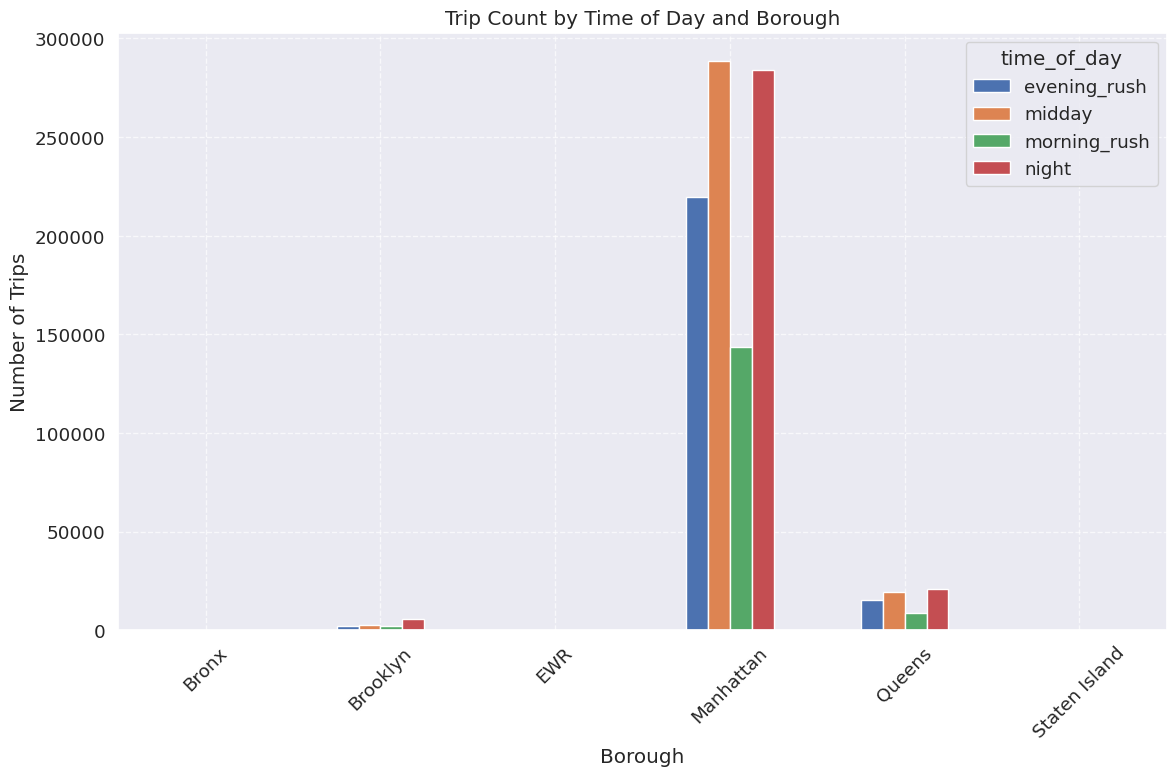

<Figure size 1400x700 with 0 Axes>

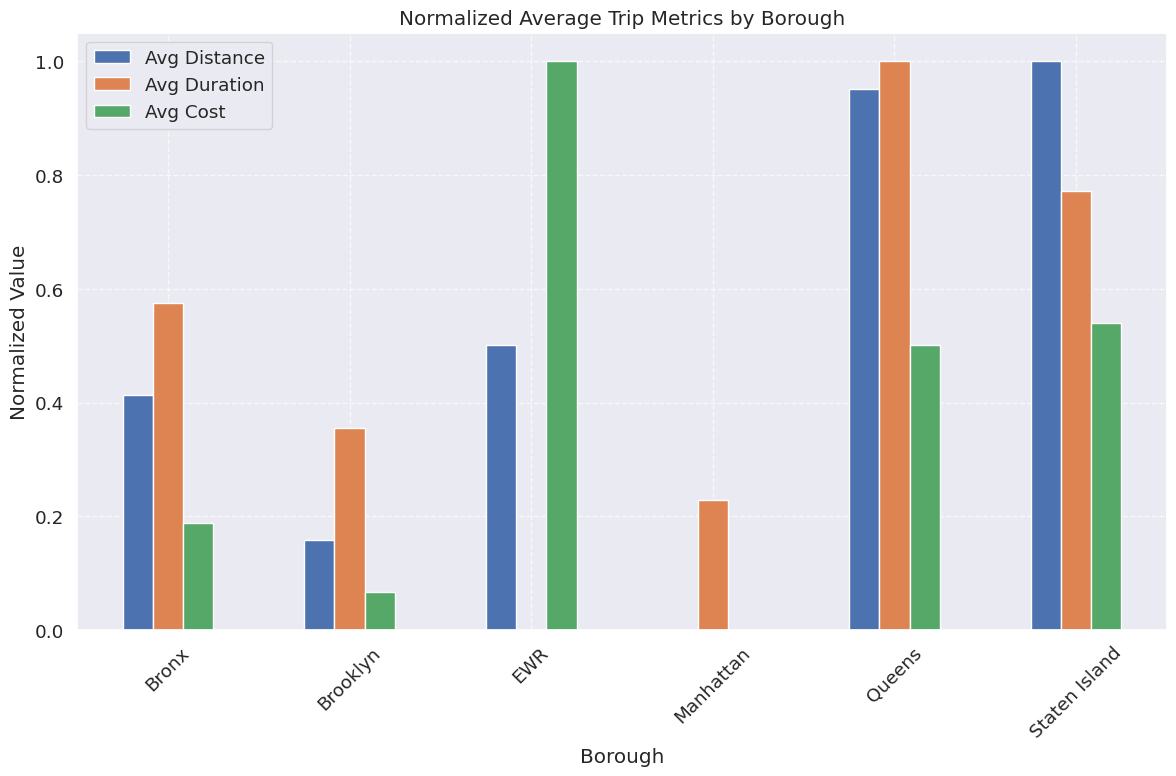

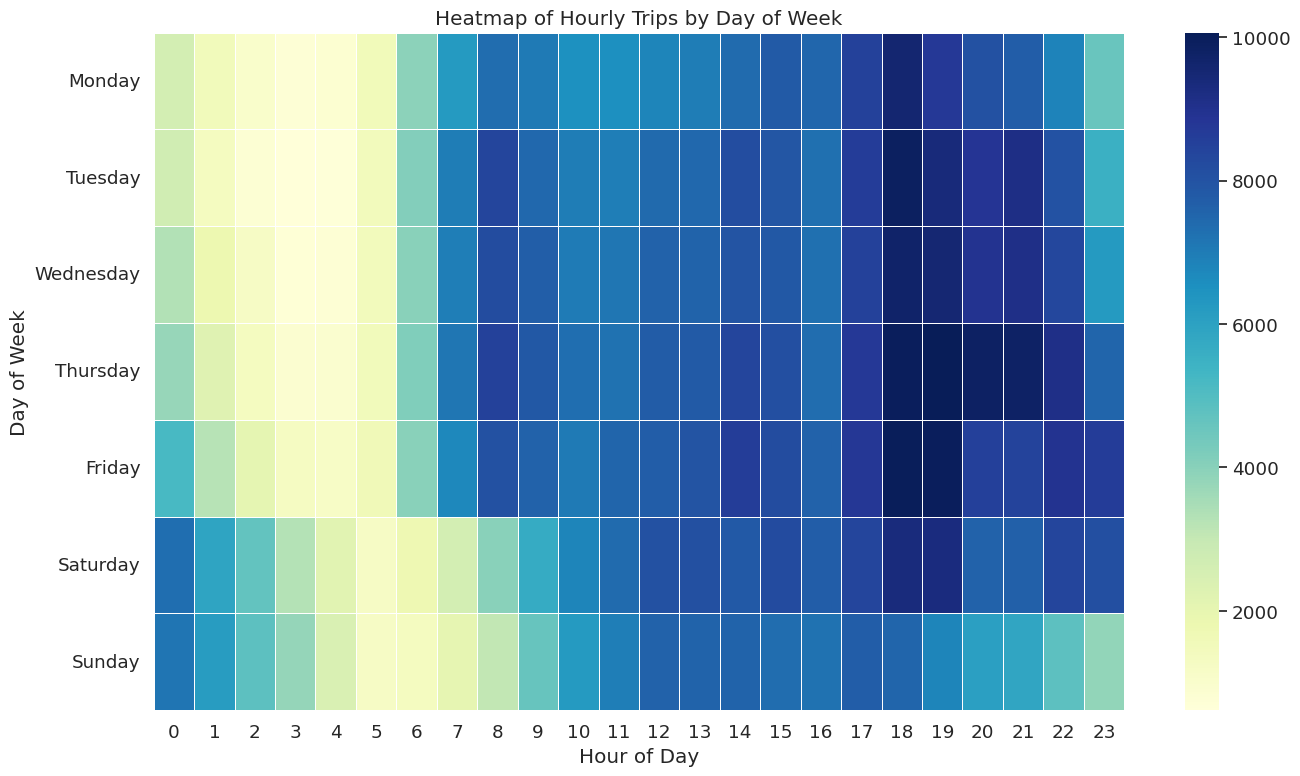

In [7]:
# Select the final columns we want to keep
final_columns = [
    # Trip identifiers and base info
    "vendor_id", "pickup_datetime", "dropoff_datetime", "passenger_count",
    
    # Location info
    "pickup_location_id", "pickup_zone_name", "pickup_borough",
    "dropoff_location_id", "dropoff_zone_name", "dropoff_borough",
    "is_inter_borough",
    
    # Trip metrics
    "trip_distance", "trip_duration_mins", "avg_speed_mph",
    
    # Financial metrics
    "fare_amount", "tip_amount", "tip_percentage", "total_cost", "cost_per_mile",
    
    # Time features
    "pickup_hour", "pickup_day", "pickup_month", "pickup_year", 
    "day_type", "time_of_day",
    
    # Payment info
    "payment_type", "rate_code"
]

final_data = complete_data.select(final_columns)

# Show sample of the final data
print("Sample of final processed data:")
final_data.show(5)

# Convert to pandas for visualization
final_data_pd = final_data.toPandas()

# Visualization 1: Trip Count by Time of Day and Borough
plt.figure(figsize=(14, 7))
borough_time_counts = final_data_pd.groupby(['pickup_borough', 'time_of_day']).size().unstack()
borough_time_counts.plot(kind='bar', stacked=False)
plt.title('Trip Count by Time of Day and Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('/root/DevDataOps/nyc-taxi-analysis/processed-data/borough_time_trips.png')
plt.show()

# Visualization 2: Average Trip Distance, Duration, and Cost by Borough
metrics_by_borough = final_data_pd.groupby('pickup_borough').agg({
    'trip_distance': 'mean',
    'trip_duration_mins': 'mean',
    'total_cost': 'mean'
}).reset_index()

# Normalize for better visualization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
metrics_by_borough[['trip_distance', 'trip_duration_mins', 'total_cost']] = scaler.fit_transform(
    metrics_by_borough[['trip_distance', 'trip_duration_mins', 'total_cost']]
)

plt.figure(figsize=(14, 7))
metrics_by_borough.set_index('pickup_borough').plot(kind='bar')
plt.title('Normalized Average Trip Metrics by Borough')
plt.xlabel('Borough')
plt.ylabel('Normalized Value')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(['Avg Distance', 'Avg Duration', 'Avg Cost'])
plt.tight_layout()
plt.savefig('/root/DevDataOps/nyc-taxi-analysis/processed-data/borough_metrics.png')
plt.show()

# Visualization 3: Heatmap of Hourly Trips by Day of Week
# Convert pickup_day from 1-7 to meaningful day names
day_map = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
final_data_pd['day_name'] = final_data_pd['pickup_day'].map(day_map)

# Create crosstab for heatmap
hourly_trips_by_day = pd.crosstab(final_data_pd['day_name'], final_data_pd['pickup_hour'])
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_trips_by_day = hourly_trips_by_day.reindex(day_order)

plt.figure(figsize=(14, 8))
sns.heatmap(hourly_trips_by_day, cmap='YlGnBu', annot=False, fmt="d", linewidths=.5)
plt.title('Heatmap of Hourly Trips by Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.savefig('/root/DevDataOps/nyc-taxi-analysis/processed-data/hourly_heatmap.png')
plt.show()

## 6. Save Processed Data

##### Prompt used: "Provide the code for creating and storing the resulting csv files based on the data cleaning and merging of the two csv files. Store them in an efficient way and for easy access."


In [8]:
# Create directory if it doesn't exist
import os
processed_data_dir = "/root/DevDataOps/nyc-taxi-analysis/processed-data"
os.makedirs(processed_data_dir, exist_ok=True)

# Save as Parquet file (efficient for big data)
parquet_path = f"{processed_data_dir}/nyc_taxi_processed.parquet"
final_data.write.mode("overwrite").parquet(parquet_path)

# Save a CSV version for easy access
csv_path = f"{processed_data_dir}/nyc_taxi_processed.csv"
final_data.write.mode("overwrite").option("header", "true").csv(csv_path)

print(f"Data saved in Parquet format: {parquet_path}")
print(f"Data saved in CSV format: {csv_path}")

# Save a sample for quick reference
sample_path = f"{processed_data_dir}/nyc_taxi_processed_sample.csv"
final_data.limit(1000).write.mode("overwrite").option("header", "true").csv(sample_path)
print(f"Sample data saved: {sample_path}")

# Print summary statistics of the final dataset
print("\nFinal Dataset Summary:")
print(f"Number of records: {final_data.count():,}")
print(f"Number of columns: {len(final_data.columns)}")

print("\nProcessed data available in the following locations:")
!ls -lh {processed_data_dir}

25/05/21 02:29:32 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/05/21 02:29:32 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Data saved in Parquet format: /root/DevDataOps/nyc-taxi-analysis/processed-data/nyc_taxi_processed.parquet
Data saved in CSV format: /root/DevDataOps/nyc-taxi-analysis/processed-data/nyc_taxi_processed.csv


Sample data saved: /root/DevDataOps/nyc-taxi-analysis/processed-data/nyc_taxi_processed_sample.csv

Final Dataset Summary:


Number of records: 1,029,406
Number of columns: 27

Processed data available in the following locations:
total 200K
-rw-r--r-- 1 root root  62K May 21 02:29 borough_metrics.png
-rw-r--r-- 1 root root  70K May 21 02:29 borough_time_trips.png
-rw-r--r-- 1 root root  49K May 21 02:29 hourly_heatmap.png
drwxr-xr-x 2 root root 4.0K May 21 02:29 nyc_taxi_processed.csv
drwxr-xr-x 2 root root 4.0K May 21 02:29 nyc_taxi_processed.parquet
drwxr-xr-x 2 root root 4.0K May 21 02:29 nyc_taxi_processed_sample.csv


## Summary (Generated by Claude Sonnet Agent)



1. **Data Quality Assessment**
   - Identified and handled missing values
   - Removed duplicate records
   - Fixed data type issues
   - Filtered out invalid data (negative distances, illogical timestamps, etc.)

2. **Feature Engineering**
   - Created trip duration in minutes
   - Calculated total trip cost
   - Added time-based features (hour, day, month, day type, time of day)
   - Added derived metrics (speed, cost per mile, tip percentage)

3. **Data Integration**
   - Joined trip data with zone data for both pickup and dropoff locations
   - Added borough information and inter-borough trip indicators

4. **Data Visualization**
   - Created visualizations of trip patterns by time and location
   - Analyzed trip metrics by borough
   - Visualized hourly trip patterns throughout the week

5. **Data Storage**
   - Saved the processed dataset in both Parquet and CSV formats
   - Included a sample dataset for quick reference

